In [1]:
import requests
from tabulate import tabulate
import numpy_financial
import pandas as pd
import math

import scipy.stats

import matplotlib
import matplotlib.pyplot as pp


In [2]:
url = 'https://nylottery.ny.gov/drupal-api/api/v2/scratch_off_data?_format=json'
r = requests.get(url)
data  = r.json()

In [3]:
Dataset = []
Spending_amount = 20

for TicketType in data['rows']:
    Array_of_Tickets = []
    try:
        Title = TicketType['title']
        Title = Title.replace('  ','')
        game_number = TicketType['game_number']
        ticket_price = float(TicketType['ticket_price'])

        # Looping through the tiers of prizes
        All_tier_prices = TicketType['odds_prizes']
        Total_Profit = 0
        Sum_of_remaining_prizes = 0
        Sum_of_remaining_and_paid_out_prizes = 0
        for Different_tier_prices in All_tier_prices:
            Tier_prizes_remaining = int(Different_tier_prices['prizes_remaining'])
            Tier_prizes_paidout = int(Different_tier_prices['prizes_paid_out'])
            
            Tier_overall_odds = Different_tier_prices['overall_odds']
            Tier_overall_odds = Tier_overall_odds.replace('1 in ','')
            Tier_overall_odds = Tier_overall_odds.replace(',','')
            Tier_overall_odds = float(Tier_overall_odds)

            prize_amount = Different_tier_prices['prize_amount']
            prize_amount = prize_amount.replace(',','')
            prize_amount = prize_amount.replace('$','')
            prize_amount = prize_amount.replace(' ','')
    
            try:
                prize_amount = float(prize_amount)
            except Exception as err:
                try:
                    Parsed_prize_amount = prize_amount[:4]
                    Parsed_prize_amount = Parsed_prize_amount.replace('$','')
                    Parsed_prize_amount = Parsed_prize_amount.replace('/','')
                    Parsed_prize_amount = Parsed_prize_amount.replace('A','')
                    Parsed_prize_amount = Parsed_prize_amount.replace('W','')
                    if 'K' in Parsed_prize_amount:
                        Parsed_prize_amount = Parsed_prize_amount.replace('K','')
                        Parsed_prize_amount = int(Parsed_prize_amount)*1000
                    if 'WK' in Different_tier_prices['prize_amount']:
                        Parsed_prize_amount = int(Parsed_prize_amount)*52
                    elif "WEEK" in Different_tier_prices['prize_amount']:
                        Parsed_prize_amount = int(Parsed_prize_amount)*52
                    Cashflow = []
                    for num in range(50):
                        Cashflow.append(Parsed_prize_amount)
                    NPV = round(numpy_financial.npv(.10, Cashflow),2)
                    prize_amount = NPV
                    
                except Exception as err:
                    if Tier_overall_odds >= 1000000:
                        Cashflow = []
                        for num in range(50):
                            Cashflow.append(ticket_price*15000)
                        NPV = round(numpy_financial.npv(.15, Cashflow),2)
                        prize_amount = NPV
                    else: 
                        prize_amount = 0 
                        
            # Adding the Remaining Tickets into an array
            for num in range(Tier_prizes_remaining):
                rounded = int(round(prize_amount,0))
                Array_of_Tickets.append(rounded)

            Total_Profit = Total_Profit + (Tier_prizes_remaining*prize_amount)
            Sum_of_remaining_prizes = Sum_of_remaining_prizes + Tier_prizes_remaining
            Sum_of_remaining_and_paid_out_prizes = Sum_of_remaining_and_paid_out_prizes + Tier_prizes_remaining + Tier_prizes_paidout

        # overall odds of pulling a winning ticket 
        overall_odds_num = TicketType['overall_odds']
        overall_odds_num = overall_odds_num.replace(':','')
        overall_odds_num = overall_odds_num.replace('\t','')
        overall_odds_num = overall_odds_num.replace(' ','')
        overall_odds_num = overall_odds_num.replace(',','')
        overall_odds_num = overall_odds_num.replace('1in','')
        overall_odds_num = overall_odds_num.replace('OddsofWinningCashPrize','')
        overall_odds_num = overall_odds_num.replace('CashOdds','')
        try:
            overall_odds_num = float(overall_odds_num)
        except:
            Rough_Estimate_of_Remaining_Tickets = (Tier_prizes_remaining + Tier_prizes_paidout)*Tier_overall_odds
            overall_odds_num = round(1/(Sum_of_remaining_and_paid_out_prizes/Rough_Estimate_of_Remaining_Tickets),2)
        overall_odds_str = "1 in {}".format(overall_odds_num)
        
        # Amount of tickets bought for excepted return
#         amount = round(overall_odds_num)
        
        amount = math.floor(Spending_amount/ticket_price)
        if amount == 0: 
            continue
        Cost_of_Tickets = amount*ticket_price

        # Calculations
        Total_remaining_tickets = round(float(overall_odds_num)*int(Sum_of_remaining_prizes),0)
        Total_amount_of_ticket_ever_made = round(float(overall_odds_num)*int(Sum_of_remaining_and_paid_out_prizes),0)
        Total_Cost = Total_remaining_tickets * ticket_price
        Total_return = round(((Total_Profit-Total_Cost)/Total_Cost) * 100,2)
        perc_remaining = round((Total_remaining_tickets/Total_amount_of_ticket_ever_made)*100,2)
        
        # Adding Losing Tickets to the array 
        Remaining_Losing_Tickets = int(round(Total_remaining_tickets - len(Array_of_Tickets),0))
        for num in range(Remaining_Losing_Tickets):
            Array_of_Tickets.append(0)
            
        df = pd.DataFrame(Array_of_Tickets, columns = ['Remaining_Tickets'])
        bootstrap = pd.DataFrame({'sumOfTickets': [df.sample(amount, replace=True).Remaining_Tickets.sum() for i in range(1000)]})
        # Chance of breaking even or better 
        Chance_BEOB = round(100-scipy.stats.percentileofscore(bootstrap.sumOfTickets, Cost_of_Tickets),2)
        # Return %
        Return_per = round(((bootstrap.sumOfTickets.mean() - Cost_of_Tickets)/Cost_of_Tickets)*100,2)

        # Sorting Volume Label
        if Total_remaining_tickets>=1000000000:
            Total_remaining_tickets = round(Total_remaining_tickets / 1000000000,0)
            Total_remaining_tickets = "{} Bill".format(Total_remaining_tickets)
        elif Total_remaining_tickets>= 1000000:
            Total_remaining_tickets = round(Total_remaining_tickets / 1000000,0)
            Total_remaining_tickets = "{} Mill".format(Total_remaining_tickets)
        elif Total_remaining_tickets>=1000:
            Total_remaining_tickets = round(Total_remaining_tickets / 1000,0)
            Total_remaining_tickets = "{} Thous".format(Total_remaining_tickets)
            
        Dataset.append([Title, Chance_BEOB, Return_per, Total_return, overall_odds_str, ticket_price, Total_remaining_tickets, perc_remaining, game_number])
        remaininglist = len(data['rows']) - len(Dataset)
        string = "There is {} remaining tickets to be checked                                                             ".format(remaininglist)
        print(string, end='\r')
        #     except ZeroDivisionError:
    except Exception as err:
        x=1
        print(Title, game_number, err)

Dataset.sort(key = lambda i: i[1])
Dataset.reverse()
Header = ['Title', '>=BE %', 'Return %', 'Total Return %','Odds', 'Price', 'Remaining', '%', 'Ticket Num']

print(tabulate(Dataset, headers = Header))


Title                             >=BE %    Return %    Total Return %  Odds         Price  Remaining        %    Ticket Num
------------------------------  --------  ----------  ----------------  ---------  -------  -----------  -----  ------------
$5,000,000 MEGA MULTIPLIER         26         -32.85            -35.89  1 in 3.33       20  1.0 Mill      5.8           1439
ALL CASH                           25.8        -1.55            -34.68  1 in 4.64       20  8.0 Mill     74.64          1571
$300,000,000 CASH PAYOUT           23.9       -26.95            -27.93  1 in 3.55       20  11.0 Mill    52.62          1528
SET FOR LIFE                       23.7       -35.3             -32.93  1 in 3.96       10  31.0 Mill    62.89          1548
CASH X50                           23.35      -28.9             -29.13  1 in 3.91       10  6.0 Mill     28.65          1554
$5,000,000 CASH ROYALE             22.9         7.95            -27.46  1 in 3.9        20  16.0 Mill    89.1           1579


In [4]:
Ticket_num = '1439'
amount = 1

Array_of_Tickets = []
for TicketType in data['rows']:
    if TicketType['game_number'] == Ticket_num:
        Title = TicketType['title']
        game_number = TicketType['game_number']
        ticket_price = float(TicketType['ticket_price'])
        Cost_of_Tickets = amount*ticket_price

        # Looping through the tiers of prizes
        All_tier_prices = TicketType['odds_prizes']
        Total_Profit = 0
        Sum_of_remaining_prizes = 0
        Sum_of_remaining_and_paid_out_prizes = 0
        for Different_tier_prices in All_tier_prices:
            Tier_prizes_remaining = int(Different_tier_prices['prizes_remaining'])
            Tier_prizes_paidout = int(Different_tier_prices['prizes_paid_out'])
            
            Tier_overall_odds = Different_tier_prices['overall_odds']
            Tier_overall_odds = Tier_overall_odds.replace('1 in ','')
            Tier_overall_odds = Tier_overall_odds.replace(',','')
            Tier_overall_odds = float(Tier_overall_odds)

            prize_amount = Different_tier_prices['prize_amount']
            prize_amount = prize_amount.replace(',','')
            prize_amount = prize_amount.replace('$','')
            prize_amount = prize_amount.replace(' ','')
    
            try:
                prize_amount = float(prize_amount)
            except Exception as err:
                try:
                    Parsed_prize_amount = prize_amount[:4]
                    Parsed_prize_amount = Parsed_prize_amount.replace('$','')
                    Parsed_prize_amount = Parsed_prize_amount.replace('/','')
                    Parsed_prize_amount = Parsed_prize_amount.replace('A','')
                    Parsed_prize_amount = Parsed_prize_amount.replace('W','')
                    if 'K' in Parsed_prize_amount:
                        Parsed_prize_amount = Parsed_prize_amount.replace('K','')
                        Parsed_prize_amount = int(Parsed_prize_amount)*1000
                    if 'WK' in Different_tier_prices['prize_amount']:
                        Parsed_prize_amount = int(Parsed_prize_amount)*52
                    elif "WEEK" in Different_tier_prices['prize_amount']:
                        Parsed_prize_amount = int(Parsed_prize_amount)*52
                    Cashflow = []
                    for num in range(50):
                        Cashflow.append(Parsed_prize_amount)
                    NPV = round(numpy_financial.npv(.10, Cashflow),2)
                    prize_amount = NPV
                    
                except Exception as err:
                    if Tier_overall_odds >= 1000000:
                        Cashflow = []
                        for num in range(50):
                            Cashflow.append(ticket_price*15000)
                        NPV = round(numpy_financial.npv(.15, Cashflow),2)
                        prize_amount = NPV
                    else: 
                        prize_amount = 0 
            # Adding the Remaining Tickets into an array
            for num in range(Tier_prizes_remaining):
                rounded = int(round(prize_amount,0))
                Array_of_Tickets.append(rounded)

            Total_Profit = Total_Profit + (Tier_prizes_remaining*prize_amount)
            Sum_of_remaining_prizes = Sum_of_remaining_prizes + Tier_prizes_remaining
            Sum_of_remaining_and_paid_out_prizes = Sum_of_remaining_and_paid_out_prizes + Tier_prizes_remaining + Tier_prizes_paidout

        # overall odds of pulling a winning ticket 
        overall_odds_num = TicketType['overall_odds']
        overall_odds_num = overall_odds_num.replace(':','')
        overall_odds_num = overall_odds_num.replace('\t','')
        overall_odds_num = overall_odds_num.replace(' ','')
        overall_odds_num = overall_odds_num.replace(',','')
        overall_odds_num = overall_odds_num.replace('1in','')
        overall_odds_num = overall_odds_num.replace('OddsofWinningCashPrize','')
        overall_odds_num = overall_odds_num.replace('CashOdds','')
        try:
            overall_odds_num = float(overall_odds_num)
        except:
            Rough_Estimate_of_Remaining_Tickets = (Tier_prizes_remaining + Tier_prizes_paidout)*Tier_overall_odds
            overall_odds_num = round(1/(Sum_of_remaining_and_paid_out_prizes/Rough_Estimate_of_Remaining_Tickets),2)
        overall_odds_str = "1 in {}".format(overall_odds_num)

        # Calculations
        Total_remaining_tickets = round(float(overall_odds_num)*int(Sum_of_remaining_prizes),0)
        Remaining_Losing_Tickets = int(round(Total_remaining_tickets - len(Array_of_Tickets),0))
        for num in range(Remaining_Losing_Tickets):
            Array_of_Tickets.append(0)
        
df = pd.DataFrame(Array_of_Tickets, columns = ['Remaining_Tickets'])
df.head()

bootstrap = pd.DataFrame({'sumOfTickets': [df.sample(amount, replace=True).Remaining_Tickets.sum() for i in range(1000)]})
round(100-scipy.stats.percentileofscore(bootstrap.sumOfTickets, Cost_of_Tickets),2)

24.3

In [5]:
round(((bootstrap.sumOfTickets.mean() - Cost_of_Tickets)/Cost_of_Tickets)*100,2)

-34.9

(13.02, 20.0)

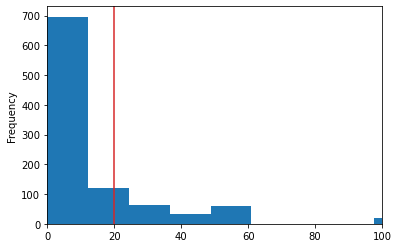

In [6]:
bins_count  = int(bootstrap.sumOfTickets.count()/24)
bootstrap.sumOfTickets.plot.hist(bins = bins_count, xlim=(0,Cost_of_Tickets*5))
pp.axvline(Cost_of_Tickets, c='C3')
bootstrap.sumOfTickets.mean(), Cost_of_Tickets

In [7]:
bootstrap.sumOfTickets.max()

500

In [8]:
round(scipy.stats.percentileofscore(bootstrap.sumOfTickets, 300),2)

99.6